In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
# Boruta for feature selection
from boruta import BorutaPy

# Set random seed for reproducibility
np.random.seed(100)


1. Data Loading and Cleaning

In [2]:
# Reading the data file
df = pd.read_csv("arrhythmia.data", header=None)
df.rename(columns={df.columns[-1]: 'Y'}, inplace=True)
#df.to_csv("arrhythmia.csv", index=False)
# Read the CSV file
#df = pd.read_csv("arrhythmia.csv")

# Replace "?" with NaN
df.replace("?", np.nan, inplace=True)

# Modify target variable:
# If Y is not equal to 1, set it to "arrhythmia"; if Y equals 1, set it to "normal"
df['Y'] = np.where(df['Y'] == 1, "normal", "arrhythmia")
print("Distribution of Y:")
print(df['Y'].value_counts())  # Should roughly match: 245 normal, 206 cardiac

# Remove columns with only one unique value
unique_counts = df.nunique()
cols_to_drop = unique_counts[unique_counts < 2].index
df.drop(columns=cols_to_drop, inplace=True)

# Remove columns with more than 10 missing values
missing_counts = df.isna().sum()
cols_to_drop = missing_counts[missing_counts > 10].index
df.drop(columns=cols_to_drop, inplace=True)

# Convert non-numeric columns (except Y) to numeric where possible
for col in df.columns:
    if col != 'Y':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Check which columns have missing values
missing_cols = df.columns[df.isna().any()].tolist()
print("Columns with missing values:", missing_cols)

# Impute all remaining missing values with the column mean
imputer = SimpleImputer(strategy='mean')
feature_cols = df.columns.difference(['Y'])
df[feature_cols] = imputer.fit_transform(df[feature_cols])
imputer = SimpleImputer(strategy='mean')
feature_cols = df.columns.difference(['Y'])
df[feature_cols] = imputer.fit_transform(df[feature_cols])
# (For 'Heart', note that the R code imputes it with the mean of T_angle. Here we use the column’s own mean.)
for col in ['QRST_angle', 'T_angle', 'Heart']:
    if col in df.columns:
        df[col].fillna(df[col].mean(), inplace=True)

# Convert Y into a categorical variable
df['Y'] = df['Y'].astype('category')

Distribution of Y:
Y
normal        245
arrhythmia    207
Name: count, dtype: int64
Columns with missing values: [10, 12, 14]


2. Scaling the Data

In [3]:
# Separate features and target
X = df.drop('Y', axis=1)
y = df['Y']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Combine scaled features with the target
df_scaled = X_scaled.copy()
df_scaled['Y'] = y.values

3. Train-Test Split

In [4]:
# Split data into 75% training and 25% testing while stratifying on Y
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled.drop('Y', axis=1),
    df_scaled['Y'],
    test_size=0.25,
    random_state=100,
    stratify=df_scaled['Y']
)

4. Feature Selection using Boruta

In [5]:
# Encode the target for Boruta (binary: normal=0, arrhythmia=1)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Use a RandomForestClassifier as the estimator for Boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=100)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=100)
boruta_selector.fit(X_train.values, y_train_enc)

# Get list of selected feature names
selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Selected features by Boruta:", selected_features)

# Create new training and testing sets with only the selected features
X_train_boruta = X_train[selected_features]
X_test_boruta = X_test[selected_features]

# For convenience, create dataframes that include the target
df_train_boruta = X_train_boruta.copy()
df_train_boruta['Y'] = y_train.values
df_test_boruta = X_test_boruta.copy()
df_test_boruta['Y'] = y_test.values

Selected features by Boruta: [4, 6, 7, 14, 75, 90, 92, 166, 168, 176, 178, 196, 198, 223, 227, 229, 247, 248, 258, 259, 276, 278]


5. Logistic Regression with Lasso Regularization (L1)

In [6]:
# Encode target as 0 and 1 (normal = 0, arrhythmia = 1)
y_train_bin = le.transform(y_train)
y_test_bin = le.transform(y_test)

lasso_model = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='roc_auc',
    random_state=10,
    max_iter=1000
)
lasso_model.fit(X_train_boruta, y_train_bin)
print("Best C for Lasso:", lasso_model.C_[0])

lasso_pred_prob = lasso_model.predict_proba(X_test_boruta)[:, 1]
lasso_pred_class = (lasso_pred_prob > 0.5).astype(int)
print("Lasso Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test_bin, lasso_pred_class))
print("Lasso Logistic Regression Accuracy:", accuracy_score(y_test_bin, lasso_pred_class))

Best C for Lasso: 0.3593813663804626
Lasso Logistic Regression Confusion Matrix:
[[33 19]
 [ 7 54]]
Lasso Logistic Regression Accuracy: 0.7699115044247787


6. Logistic Regression with Ridge Regularization (L2)

In [7]:
ridge_model = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l2',
    solver='liblinear',
    scoring='roc_auc',
    random_state=10,
    max_iter=1000
)
ridge_model.fit(X_train_boruta, y_train_bin)
print("Best C for Ridge:", ridge_model.C_[0])
ridge_pred_prob = ridge_model.predict_proba(X_test_boruta)[:, 1]
ridge_pred_class = (ridge_pred_prob > 0.5).astype(int)

print("\nRidge Logistic Regression Results:")
print("Ridge Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test_bin, ridge_pred_class))
print("Ridge Logistic Regression Accuracy:", accuracy_score(y_test_bin, ridge_pred_class))

Best C for Ridge: 0.046415888336127774

Ridge Logistic Regression Results:
Ridge Logistic Regression Confusion Matrix:
[[34 18]
 [ 7 54]]
Ridge Logistic Regression Accuracy: 0.7787610619469026


7. K-Nearest Neighbors (KNN)

In [8]:
knn_param_grid = {'n_neighbors': list(range(1, 51))}
knn = KNeighborsClassifier()
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
knn_grid = GridSearchCV(knn, knn_param_grid, scoring='roc_auc', cv=cv_strategy, n_jobs=-1)
knn_grid.fit(X_train_boruta, y_train_bin)
print("Best k in KNN:", knn_grid.best_params_['n_neighbors'])

knn_pred_class = knn_grid.predict(X_test_boruta)
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test_bin, knn_pred_class))
print("KNN Accuracy:", accuracy_score(y_test_bin, knn_pred_class))

Best k in KNN: 7
KNN Confusion Matrix:
[[31 21]
 [ 3 58]]
KNN Accuracy: 0.7876106194690266


8. Random Forest

In [9]:
# Define a grid for max_features (the equivalent of mtry)
num_features = len(selected_features)
rf_param_grid = {'max_features': list(range(1, num_features + 1))}
rf_model = RandomForestClassifier(random_state=123, n_estimators=100)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train_boruta, y_train)
print("Best max_features in RF:", rf_grid.best_params_['max_features'])

rf_pred = rf_grid.predict(X_test_boruta)
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Best max_features in RF: 7
Random Forest Confusion Matrix:
[[43  9]
 [ 6 55]]
Random Forest Accuracy: 0.8672566371681416


 9. Gradient Boosting (GBM)

In [10]:
gbm_param_grid = {
    'n_estimators': [500, 2500, 5000],
    'max_depth': [1, 2, 4], # equivalent to interaction.depth
    'learning_rate': [0.001, 0.01, 0.1, 1, 4],  # shrinkage
    'min_samples_leaf': [10] # equivalent to n.minobsinnode
}
gbm_model = GradientBoostingClassifier(random_state=123)
gbm_grid = GridSearchCV(gbm_model, gbm_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
gbm_grid.fit(X_train_boruta, y_train_bin)
print("Best parameters for GBM:", gbm_grid.best_params_)
gbm_pred = gbm_grid.predict(X_test_boruta)
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test_bin, gbm_pred))
print("Gradient Boosting Accuracy:", accuracy_score(y_test_bin, gbm_pred))

Best parameters for GBM: {'learning_rate': 0.01, 'max_depth': 1, 'min_samples_leaf': 10, 'n_estimators': 2500}
Gradient Boosting Confusion Matrix:
[[43  9]
 [ 7 54]]
Gradient Boosting Accuracy: 0.8584070796460177


10. Decision Tree

Best max_depth for Decision Tree: 8
Decision Tree Confusion Matrix:
[[34 18]
 [11 50]]
Decision Tree Accuracy: 0.7433628318584071


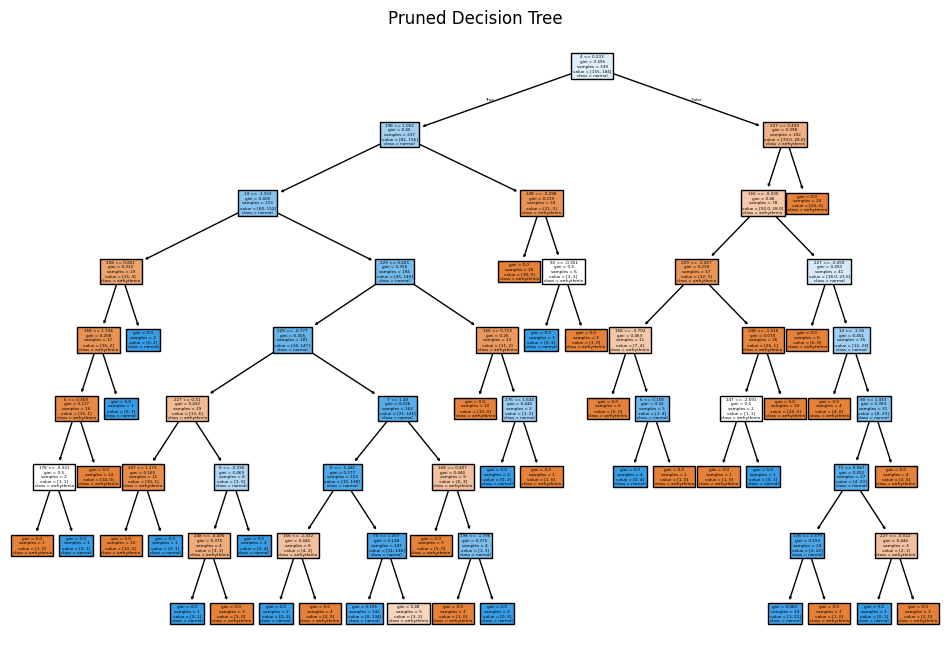

In [11]:
dt_param_grid = {'max_depth': range(1, 20)}
dt_model = DecisionTreeClassifier(random_state=1)
dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=5, n_jobs=-1)
dt_grid.fit(X_train_boruta, y_train)
print("Best max_depth for Decision Tree:", dt_grid.best_params_['max_depth'])

dt_pred = dt_grid.predict(X_test_boruta)
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_pred))
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))

# Plot the pruned decision tree (best estimator)
plt.figure(figsize=(12, 8))
plot_tree(dt_grid.best_estimator_,
          feature_names=X_train_boruta.columns,
          class_names=le.classes_,
          filled=True)
plt.title("Pruned Decision Tree")
plt.show()


11. Support Vector Machine (Radial Kernel)

In [12]:
# Prepare a grid for C and gamma. Note: the ranges are exponential.
C_range = [2**i for i in range(-5, 16)]
gamma_range = [2**i for i in range(-15, 4)]
svm_param_grid = {'C': C_range, 'gamma': gamma_range}
svm_rbf = SVC(kernel='rbf', probability=True, random_state=123)
svm_grid = GridSearchCV(svm_rbf, svm_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
svm_grid.fit(X_train_boruta, y_train_bin)
print("Best parameters for SVM RBF:", svm_grid.best_params_)

svm_pred = svm_grid.predict(X_test_boruta)
print("SVM RBF Confusion Matrix:")
print(confusion_matrix(y_test_bin, svm_pred))
print("SVM RBF Accuracy:", accuracy_score(y_test_bin, svm_pred))

Best parameters for SVM RBF: {'C': 4, 'gamma': 0.25}
SVM RBF Confusion Matrix:
[[42 10]
 [16 45]]
SVM RBF Accuracy: 0.7699115044247787


12. Support Vector Classifier (Linear SVM)

In [13]:
svc_param_grid = {'C': [0.001, 0.05, 0.01, 0.1, 1, 5, 10, 100]}
svc = SVC(kernel='linear', probability=True, random_state=123)
svc_grid = GridSearchCV(svc, svc_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
svc_grid.fit(X_train_boruta, y_train_bin)
print("Best parameters for SVC (linear):", svc_grid.best_params_)

svc_pred = svc_grid.predict(X_test_boruta)
print("Support Vector Classifier (Linear) Confusion Matrix:")
print(confusion_matrix(y_test_bin, svc_pred))
print("SVC (Linear) Accuracy:", accuracy_score(y_test_bin, svc_pred))


Best parameters for SVC (linear): {'C': 0.05}
Support Vector Classifier (Linear) Confusion Matrix:
[[35 17]
 [ 8 53]]
SVC (Linear) Accuracy: 0.7787610619469026


13. Neural Network

In [14]:
nn_param_grid = {
    'hidden_layer_sizes': [(3,), (4,), (5,), (6,), (7,)],
    'alpha': [0.5, 0.1]  # equivalent to weight decay
}
nn = MLPClassifier(max_iter=2000, random_state=1, early_stopping=True, n_iter_no_change=20)
cv_nn = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
nn_grid = GridSearchCV(nn, nn_param_grid, cv=cv_nn, n_jobs=-1, scoring='roc_auc')
nn_grid.fit(X_train_boruta, y_train_bin)
print("Best parameters for Neural Network:", nn_grid.best_params_)

nn_pred = nn_grid.predict(X_test_boruta)
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test_bin, nn_pred))
print("Neural Network Accuracy:", accuracy_score(y_test_bin, nn_pred))

Best parameters for Neural Network: {'alpha': 0.1, 'hidden_layer_sizes': (7,)}
Neural Network Confusion Matrix:
[[42 10]
 [42 19]]
Neural Network Accuracy: 0.5398230088495575
